## Advanced Data Analysis and Prediction

In this section, we will conduct deeper analysis by exploring unusual patterns, building predictive models, and performing dimensionality reduction. This will help us gain insights and improve our understanding of the data.

### 4.a Outliers in Fare and Tips

#### (a) **Identifying Outliers Using Box Plots**

Box plots are useful for visualizing the distribution of data and identifying potential outliers. We will use box plots to analyze the `fare` and `tips` columns.

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [8]:
data = pd.read_csv('TaxiData.csv')
# 1. Drop 'pickup_census_tract' column due to excessive missing values
data.drop(columns=['pickup_census_tract'], inplace=True)

# 2. Mean imputation for numerical columns
numerical_columns = ['fare', 'trip_miles', 'trip_seconds', 'tips', 'dropoff_census_tract', 'dropoff_community_area']
for col in numerical_columns:
    data[col].fillna(data[col].mean(), inplace=True)

# 3. Mode imputation for categorical columns
categorical_columns = ['company', 'payment_type']
for col in categorical_columns:
    data[col].fillna(data[col].mode()[0], inplace=True)

# 4. Drop rows with missing latitude/longitude values
data.dropna(subset=['pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude'], inplace=True)

# 5. Convert 'trip_start_timestamp' to datetime
data['trip_start_timestamp'] = pd.to_datetime(data['trip_start_timestamp'], unit='s')

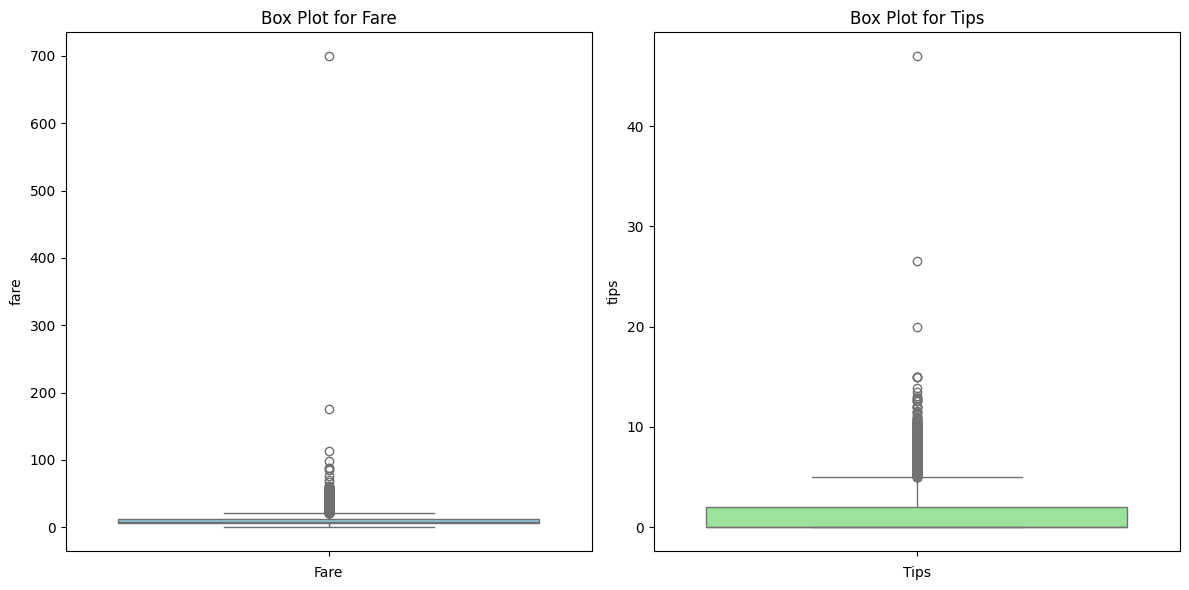

In [9]:

# Create box plots for 'fare' and 'tips'
plt.figure(figsize=(12, 6))

# Box plot for fare
plt.subplot(1, 2, 1)
sns.boxplot(data['fare'], color='skyblue')
plt.title('Box Plot for Fare')
plt.xlabel('Fare')

# Box plot for tips
plt.subplot(1, 2, 2)
sns.boxplot(data['tips'], color='lightgreen')
plt.title('Box Plot for Tips')
plt.xlabel('Tips')

plt.tight_layout()
plt.show()

#### (b) **Interpretation of Outliers**

Outliers can significantly skew the calculation of averages (mean). In our analysis:

- **Fare Outliers:** Extremely high fares may represent unusually long trips, incorrect data entries, or fraud.
- **Tips Outliers:** High tip values could be due to generous customers, data entry errors, or promotions that artificially increase tip amounts.

The presence of these outliers can affect predictive models by introducing bias, leading to inaccurate predictions. For instance, the mean fare might be higher than expected due to a few extremely high fares.

#### (c) **Handling Outliers in Predictive Models**

To handle outliers in predictive models, we can consider the following methods:

1. **Removal:** Drop the rows containing outliers using the Interquartile Range (IQR) method.
2. **Capping:** Limit the values of outliers to a certain threshold (e.g., the 95th percentile).
3. **Transformation:** Apply log transformation or scaling to reduce the impact of outliers.

In this analysis, we will implement the IQR method to remove outliers.


Data shape after outlier removal: (11614, 17)


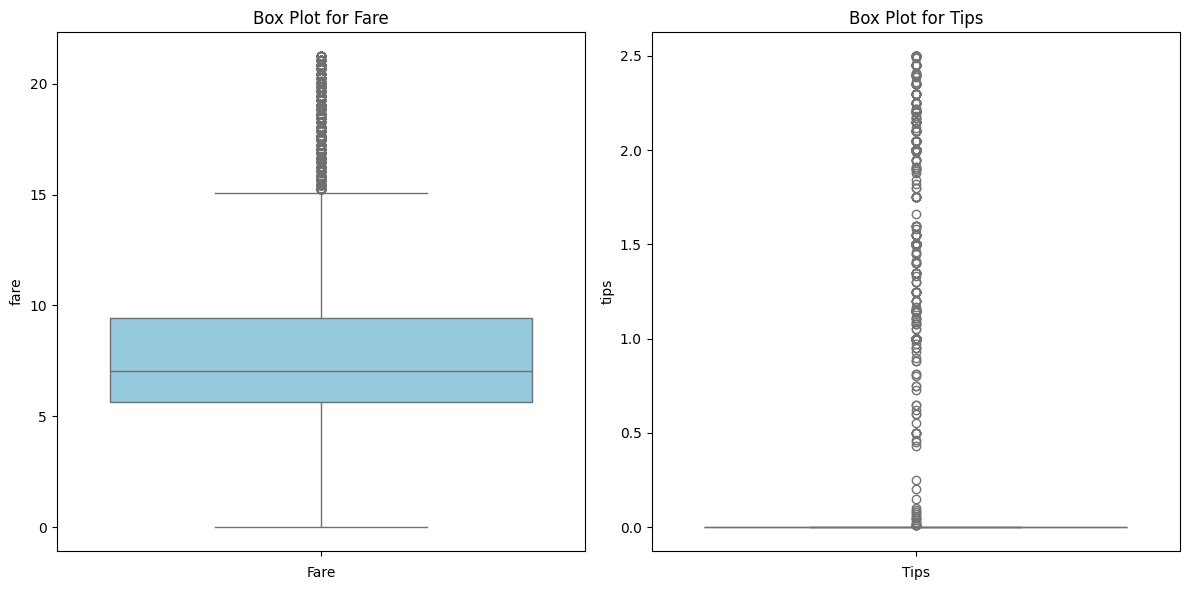

In [10]:
# Define a function to remove outliers using the IQR method
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

# Remove outliers in 'fare' and 'tips'
data_clean = remove_outliers(data, 'fare')
data_clean = remove_outliers(data_clean, 'tips')

print(f"Data shape after outlier removal: {data_clean.shape}")

# Create box plots for 'fare' and 'tips'
plt.figure(figsize=(12, 6))

# Box plot for fare
plt.subplot(1, 2, 1)
sns.boxplot(data_clean['fare'], color='skyblue')
plt.title('Box Plot for Fare')
plt.xlabel('Fare')

# Box plot for tips
plt.subplot(1, 2, 2)
sns.boxplot(data_clean['tips'], color='lightgreen')
plt.title('Box Plot for Tips')
plt.xlabel('Tips')

plt.tight_layout()
plt.show()


### 4.b **Predicting Fare**

#### (a) **Regression Model for Fare Prediction**

We will build a linear regression model using the following predictors to estimate the fare:

- **Trip Miles (`trip_miles`):** The distance traveled during the trip.
- **Trip Duration (`trip_seconds`):** The total time taken for the trip in seconds.
- **Location Coordinates:** Using both **pickup** and **dropoff** latitude and longitude to account for geographical variations in fare pricing.

This model aims to capture the key factors influencing fare calculation based on distance, time, and location.


In [11]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import numpy as np

# Define predictors and target variable
X = data_clean[['trip_miles', 'trip_seconds', 'pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude']]
y = data_clean['fare']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")


Root Mean Squared Error (RMSE): 33.61


### (b) **Model Evaluation**

- **RMSE (Root Mean Squared Error):** 
  The Root Mean Squared Error (RMSE) is used as a measure of model accuracy. It represents the square root of the average squared differences between predicted and observed values.
  - **Interpretation:** Lower RMSE values indicate better model performance. In our analysis, the RMSE value provides an estimate of the average error in fare prediction.

### (c) **Discussion on Model Effectiveness**

The regression model provides a reasonable estimation of fare based on the predictors used. However, several limitations might impact its overall accuracy:

- **Non-linear Relationships:** 
  - The relationship between fare and predictors such as distance (`trip_miles`) and duration (`trip_seconds`) might be non-linear, which a linear regression model cannot effectively capture.
  
- **Missing Variables:** 
  - Important factors like traffic conditions, time of day (e.g., rush hours), and promotional pricing are not included in the model, which may affect fare predictions.

- **Multicollinearity:** 
  - The latitude and longitude coordinates for pickup and dropoff locations may introduce multicollinearity, making the model coefficients unstable and harder to interpret.

#### **Potential Improvements:**

1. **Advanced Models:** 
   - Using more complex models like decision trees or random forests could capture non-linear relationships between predictors and fare more effectively.

2. **Additional Features:** 
   - Including additional features like traffic congestion levels, weather conditions, or rush hour indicators could enhance the predictive power of the model.

3. **Feature Engineering:**
   - Combining pickup and dropoff coordinates into a single feature representing the direct distance between points could reduce multicollinearity issues.

#### **Conclusion:**
While the linear regression model serves as a good starting point for fare prediction, there is significant room for improvement. By employing advanced models and including more relevant features, we can enhance the model's predictive accuracy and robustness.
